# Using OpenSTL in your own project

In this notebook, we will provide a comprehensive guide on how to use OpenSTL for your own project. 

Firstly, we will process video data into `.npy` format for easier storage and access. Next, we will demonstrate how to utilize custom data within OpenSTL. Subsequently, we will use OpenSTL to train and evaluate models. Finally, we will visualize predicted frames and generate `.gif` images or videos. 

- [1. Preprocess your data](#1-process-your-data)
    - [1.1 Save the dataset](#11-save-the-dataset)
    - [1.2 Load the dataset and visualize an example](#12-load-the-dataset-and-visualize-an-example)

- [2. Utilize cumtom data](#2-utilize-cumtom-data)
    - [2.1 Define the dataset](#21-define-the-dataset)
    - [2.2 Get the dataloaders](#22-get-the-dataloaders)

- [3. Train and evaluate](#3-train-and-evaluate)
    - [3.1 Define the custom configs](#31-define-the-custom-configs)
    - [3.2 Setup the experiment](#32-setup-the-experiment)
    - [3.3 Start training and evaluation](#33)

- [4. Visualization](#4-visualization)
    - [4.1 Visualize in a line](#41-visualize-in-a-line)
    - [4.2 Generate a GIF](#42-generate-a-gif)

Here we go!

## 1. Process your data

Assume you possess a collection of videos and have already sorted them into the `train/`, `val/`, and `test/` directories. The subsequent step involves transforming these videos into a `.pkl` file for further manipulations.

The existing file hierarchy is as follows:

- custom_usage.ipynb
- train
  - train_example1.avi
  - train_example2.avi
- val
  - val_example1.avi
  - val_example2.avi
- test
  - test_example.avi

It's crucial to note that the above example represents a simplified scenario where we've used `.avi` videos for illustrative purposes. However, in a real-world application, you are free to employ videos in various other formats.

We utilize several videos from the KTH dataset as examples. Although the original KTH dataset consists of single-channel grayscale videos, we save them as three-channel RGB videos to accommodate a broader range of use cases.

### 1.1 Save the dataset

Here, we default to uniformly sampling several frames from the given video data. The number of observed frames and future frames are two hyperparameters (`pre_seq_length`, `aft_seq_length`) that are set in advance. You can also choose to sample the video in other ways and save the data.

#### hyperparameters

`pre_seq_length`: the number of given frames

`aft_seq_length`: the number of frames to predict

### 1.2 Load the dataset and visualize an example

In [1]:
import pickle
import cv2
import numpy as np
import os
import time
import torch
from torch.utils.data import Dataset
import re
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
import torch.nn.functional as F

from openstl.utils import show_video_line
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

In [2]:
pre_seq_length = 12
aft_seq_length = 12

# load the dataset
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(train_x.shape)
# the shape is B x T x C x H x W
# B: the number of samples
# T: the number of frames in each sample
# C, H, W: the channels, height and width  of each frame

(1735, 12, 1, 144, 144)


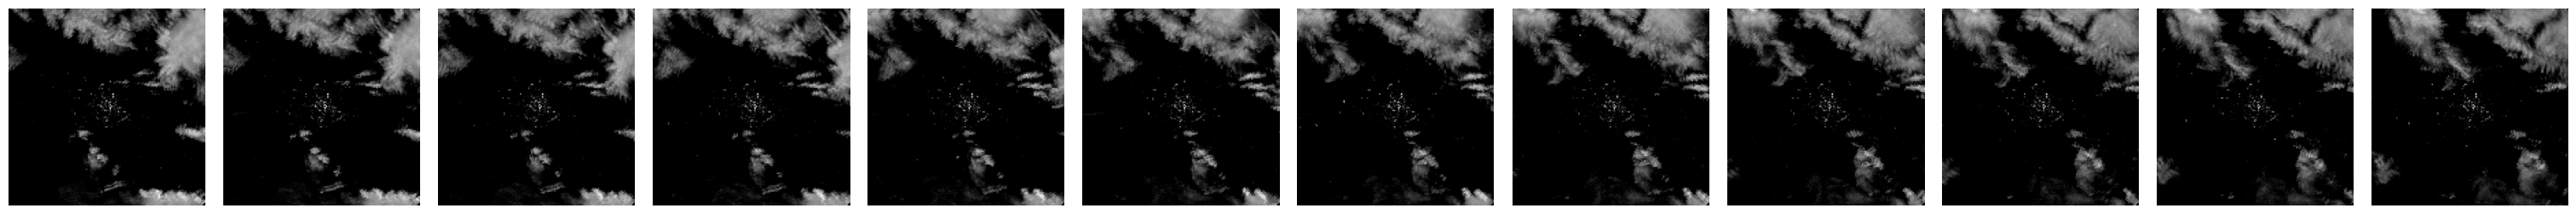

In [3]:
# show the given frames from an example
example_idx = 0
show_video_line(train_x[example_idx], ncols=pre_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

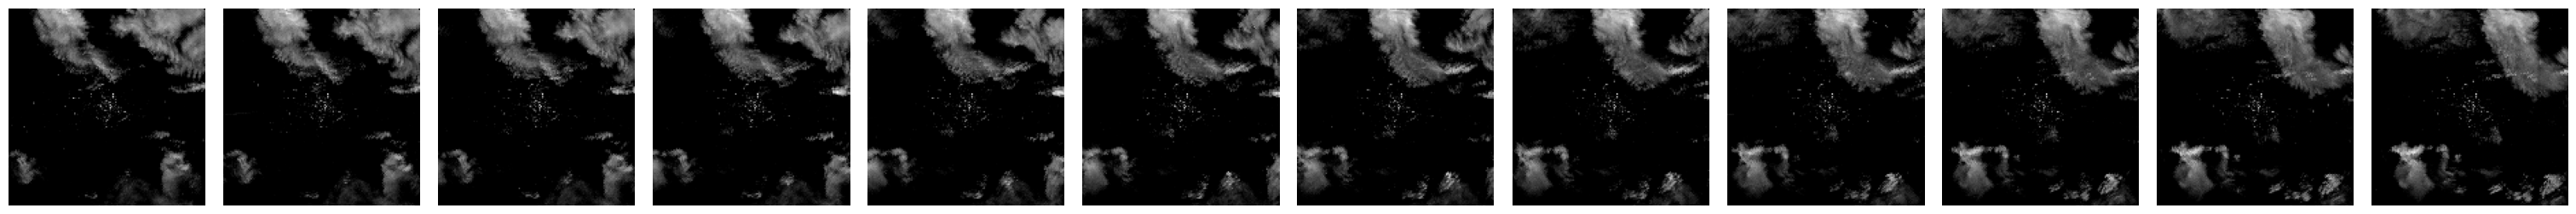

In [4]:
# show the future frames from an example
example_idx = 0
show_video_line(train_y[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

## 2. Utilize cumtom data

### 2.1 Define the dataset

We first define the `CustomDataset` to use the provided dataset. 

For real video prediction, to facilitate model optimization, we strongly recommend users to use frames represented as `float32` with values in the range of $[0, 1]$, rather than frames represented as `uint8` with values in the range of $[0, 255]$. For other types of data, we also provide the option to `normalize` in the `CustomDataset`.

In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False, data_name = "custom"):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None
        self.data_name = data_name

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

#### hyperparameters

`batch_size`: the size of a batch

In [6]:
batch_size = 4

In [7]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)

In [8]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

## 3. Train and evaluate

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

In [9]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': 1,
    'epoch': 1,
    'lr': 0.001,   
    'metrics': ['mae', 'mse'],
    "drop": 0.1,
    'drop_path': 0.1,
    "weight_decay": 0.05,
    'sched': 'onecycle',
    'fps': False,

    "num_workers": 	8,
    "warmup_epoch": 	5,
    "warmup_lr": 	1e-06,
    
    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [12, 1, 144, 144],
}

custom_model_config = {
    'method': 'SimVP', #SimVP #PredRNNv2 # MMVP #SwinLSTM #WaST
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py', there are example for all models parameters in /configs

    #loss function for simVP models, tau, phydnet
    'loss': 'weight', # 'mse', 'mae', 'weight', 'msce', 'weightmsce', vggperceptual
    
    
    # #MMVP
    # "downsample_setting": '2,2,2',
    # "hid_S": 16,
    # "hid_T": 96,
    # "rrdb_encoder_num": 2,
    # "rrdb_decoder_num": 2
}

ConvLSTM_training_config = {
    # ConvLSTM
    # reverse scheduled sampling
    "reverse_scheduled_sampling" : 0,
    "r_sampling_step_1" : 25000,
    "r_sampling_step_2" : 50000,
    "r_exp_alpha" : 5000,
    # scheduled sampling
    "scheduled_sampling" : 1,
    "sampling_stop_iter" : 50000,
    "sampling_start_value" : 1.0,
    "sampling_changing_rate" : 0.00002,
    # model
    "num_hidden" : '32,32,32,32',
    "filter_size" : 5,
    "stride" : 1,
    "patch_size" : 2,
    "layer_norm" : 0
}

PredRNNv2_training_config = {
    #PredRNNv2
    'num_hidden': '128,128,128,128',
    'filter_size': 5,
    'stride': 1,
    'patch_size': 2,
    'layer_norm': 0,
    'decouple_beta': 0.1,
    # reverse scheduled sampling
    'reverse_scheduled_sampling': 1,
    'r_sampling_step_1': 25000,
    'r_sampling_step_2': 50000,
    'r_exp_alpha': 5000,
    # scheduled sampling
    'scheduled_sampling': 1,
    'sampling_stop_iter': 50000,
    'sampling_start_value': 1.0,
    'sampling_changing_rate': 0.00002
}

SimVP_training_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    
    # Here, we directly set these parameters
    'model_type': 'swin', #Swin #MogaNET 
    'N_S': 4, #4
    'N_T': 8, #8
    'hid_S': 64, #64
    'hid_T': 256, #512
    'spatio_kernel_enc': 3,
    'spatio_kernel_dec': 3,    
}

SwinLSTM_D_training_config = {
    # SwinLSTM_D
    "depths_downsample" : '2,6',
    "depths_upsample" : '6,2',
    "num_heads": '4,8',
    "patch_size": 2,
    "window_size": 2,
    "embed_dim": 32,
}

WaST_training_config = {
   # WaST
    'encoder_dim': 20,
    'block_list': [2, 8, 2],
    'mlp_ratio': 4.0,
    'loss_weight': 0.001,
    # drop scheduler
    "cutmode": "late",  # early or late
    "cutoff": 20
}

model_config = globals()[custom_model_config['method'] + '_training_config']

custom_training_config.update(model_config)

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`. 

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [10]:
args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)
# fulfill with default values
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test),strategy="dp")

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation. 

Here we go!

In [11]:
torch.set_float32_matmul_precision('high')  #Choose matrix mutiplication precision between "highest" "high" "medium"

print('>'*35 + ' training ' + '<'*35)
start_time = time.time()
exp.train()
train_time = time.time() - start_time
print('>'*35 + ' testing  ' + '<'*35)
exp.test()

Missing logger folder: tb_logs\simvp_weight_1epochs_3
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<



  | Name      | Type        | Params
------------------------------------------
0 | model     | SimVP_Model | 21.9 M
1 | criterion | WeightLoss  | 0     
------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.577    Total estimated model params size (MB)


Environment info:
------------------------------------------------------------
sys.platform: win32
Python: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:33) [MSC v.1929 64 bit (AMD64)]
CUDA available: True
CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.3
NVCC: Not Available
GPU 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GCC: <built-in method strip of str object at 0x000002182F2B1C50>
PyTorch: 2.1.0+cu118
PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 434: 'val_loss' reached 0.01379 (best 0.01379), saving model to 'work_dirs\\custom_exp\\checkpoints\\best-epoch=00-val_loss=0.014-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         1.09%     118.396ms       100.00%       10.818s     540.881ms      62.263ms   

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


Testing: 0it [00:00, ?it/s]

mse:214.18743896484375, mae:1368.93505859375


TEST Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         1.21%     122.188ms       100.00%       10.135s     506.772ms     105.687ms         1.04%       10.136s     506.801ms            20  
[pl][profile][Strategy]DataParallelStrategy.test_ste...         0.06%       6.057ms        82.89%        8.402s     420.088ms       5.916ms         0.06%      

### 4 Saving visualisation, metrics and model parameters

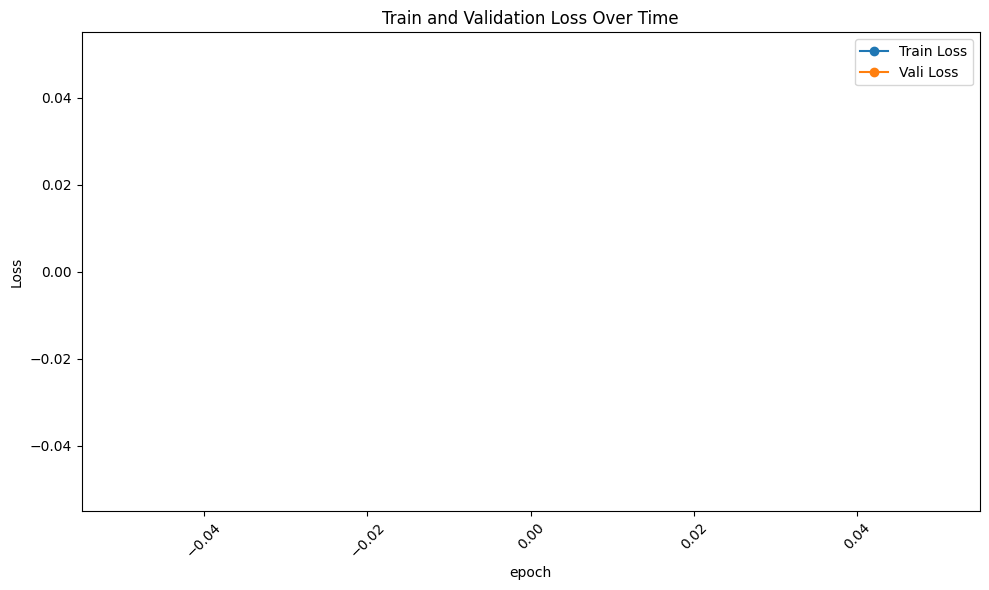

<Figure size 640x480 with 0 Axes>

In [12]:
#Check if the folder exists
if not os.path.exists("work_dirs/custom_exp/models"):
    # Create the folder if it doesn't exist
    os.makedirs("work_dirs/custom_exp/models")


def parse_log_line(line):
    """
    Look at the losses from the log file during training and validation.
    """
    match = re.search(r'Train Loss: (\d+\.\d+) \| Vali Loss: (\d+\.\d+)', line)
    if match:
        train_loss = float(match.group(1))
        val_loss = float(match.group(2))
        return train_loss, val_loss
    else:
        return None

def plot_losses(log_file):
    """
    Plot the training and validation losses over the epochs.
    """
    train_losses = []
    val_losses = []
    timestamps = []

    with open(log_file, 'r') as file:
        epoch = 0
        epochs = []
        for line in file:

            losses = parse_log_line(line)
            if losses:
                train_loss, val_loss = losses
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                epoch+=1
                epochs.append(epoch)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Vali Loss', marker='o')
    plt.title('Train and Validation Loss Over Time')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"work_dirs/custom_exp/models/{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}_losses.jpg")

# Example usage
log_file_path = f'./work_dirs/custom_exp/{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}.log'
plot_losses(log_file_path)

In [13]:
# Function to extract params and FLOPs from the log file
def extract_model_info(file_path):
    # Read the content of the file
    with open(file_path, 'r') as file:
        content = file.read()

    # Use regular expressions to extract the nb of params and FLOPs
    match = re.search(r'\| [^\s]+\s*\| ([0-9]*\.[0-9]+[TGM])+\s*\| ([0-9]*\.[0-9]+[TGM])+\s*\|', content, re.DOTALL)

    if match:
        params_size = match.group(1)
        flops = match.group(2)

        return params_size, flops
    else:
        return "Model information not found in the file."

nb_params, flops = extract_model_info(log_file_path)

In [14]:
# load the inputs, predictions and ground truth from the saved numpy arrays
inputs = np.load(f'./work_dirs/custom_exp/saved/inputs_{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}.npy')
preds = np.load(f'./work_dirs/custom_exp/saved/preds_{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}.npy')
trues = np.load(f'./work_dirs/custom_exp/saved/trues_{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}.npy')

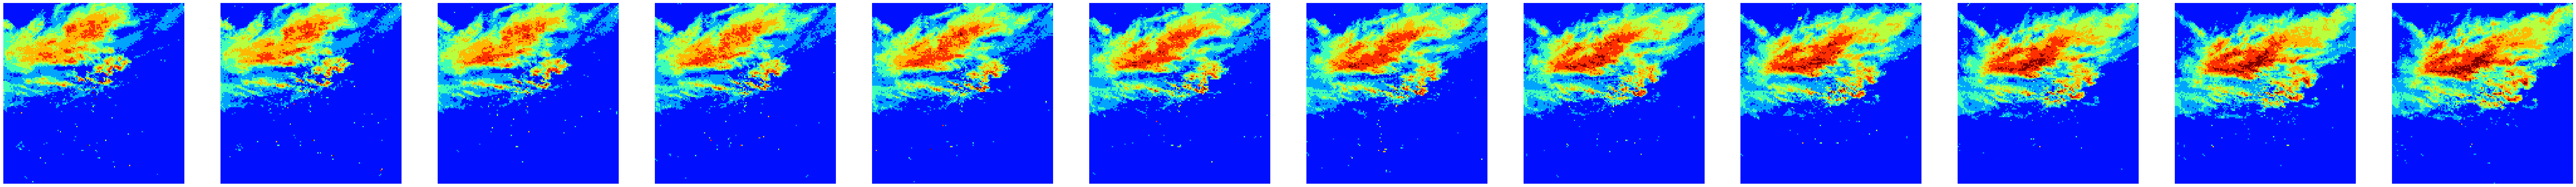

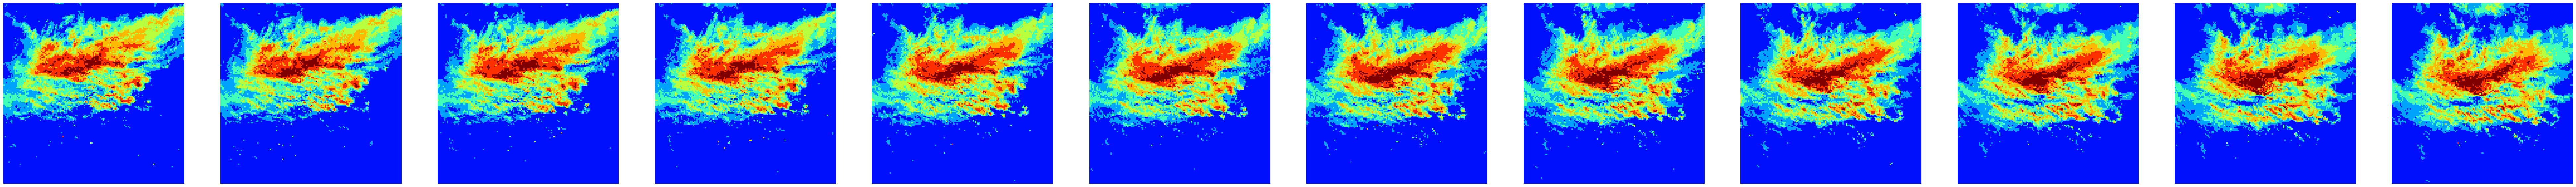

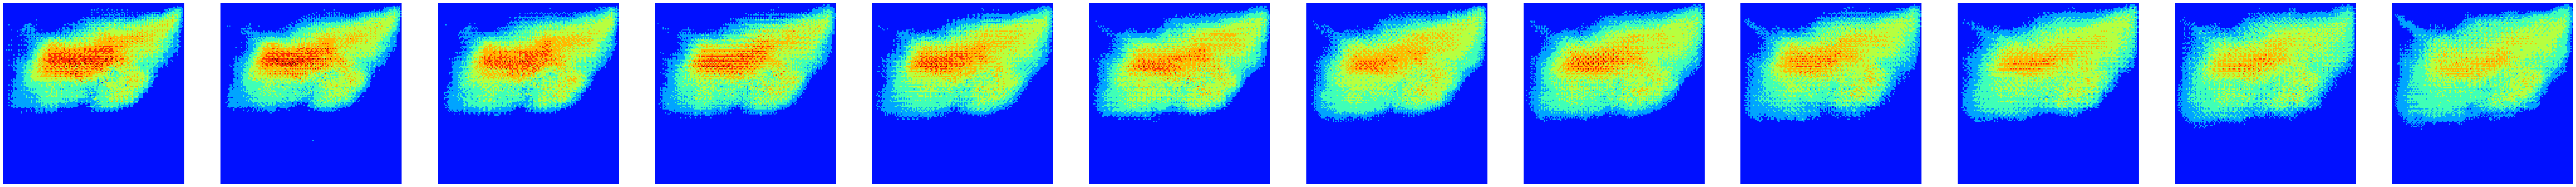

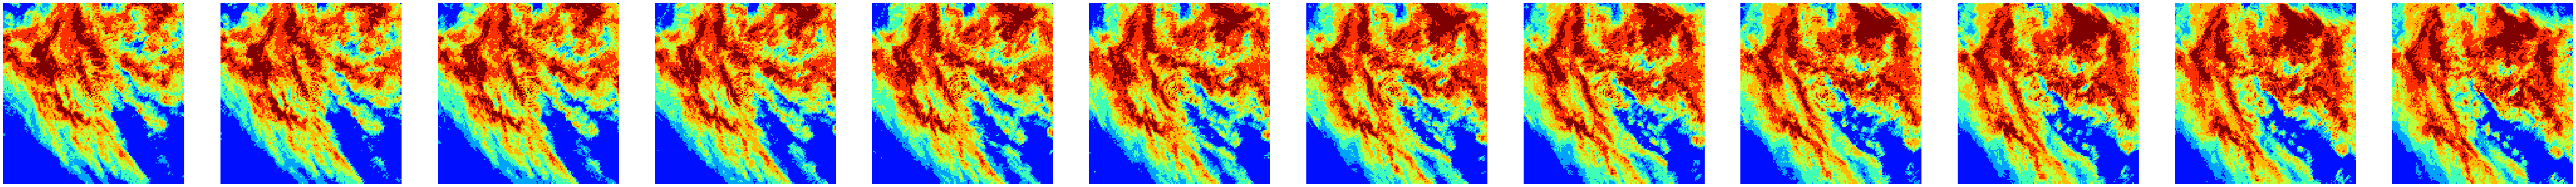

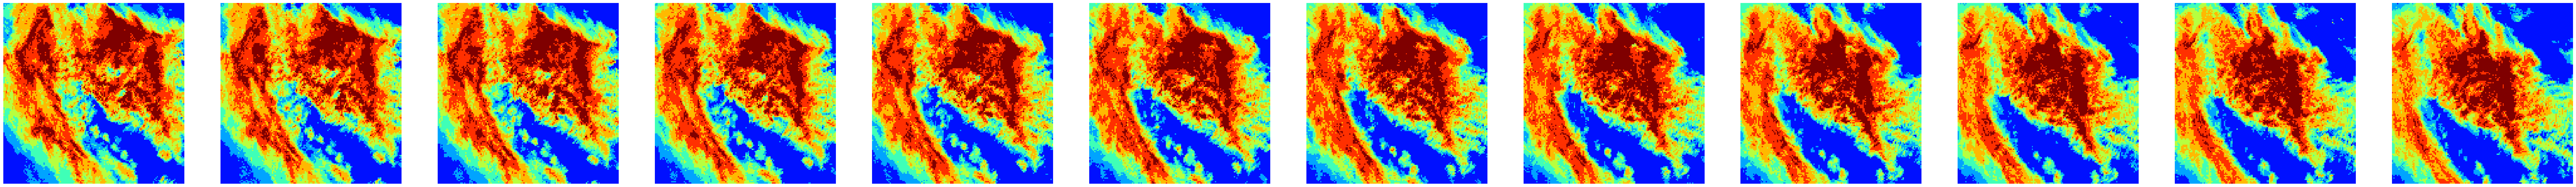

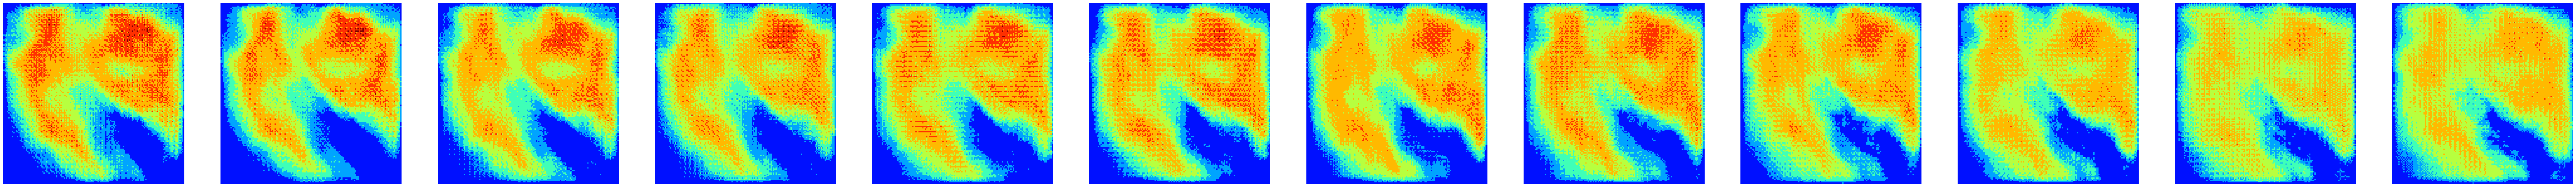

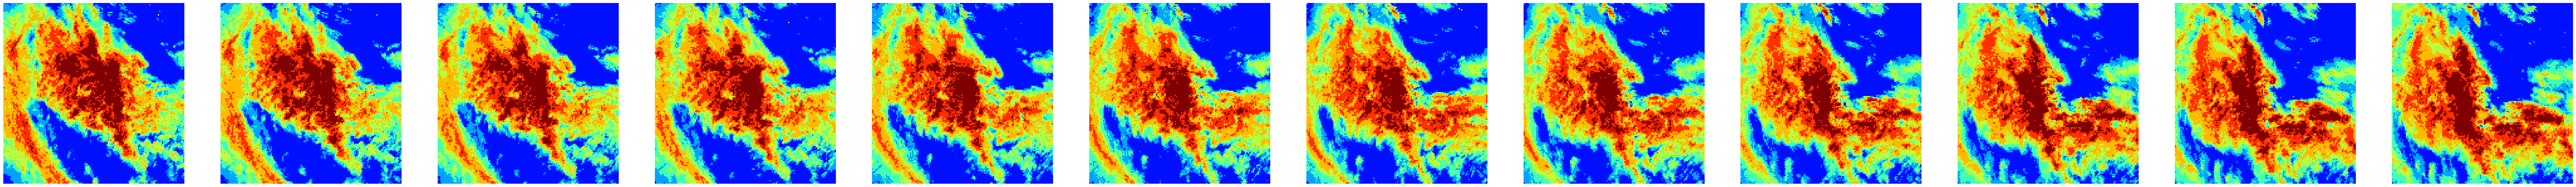

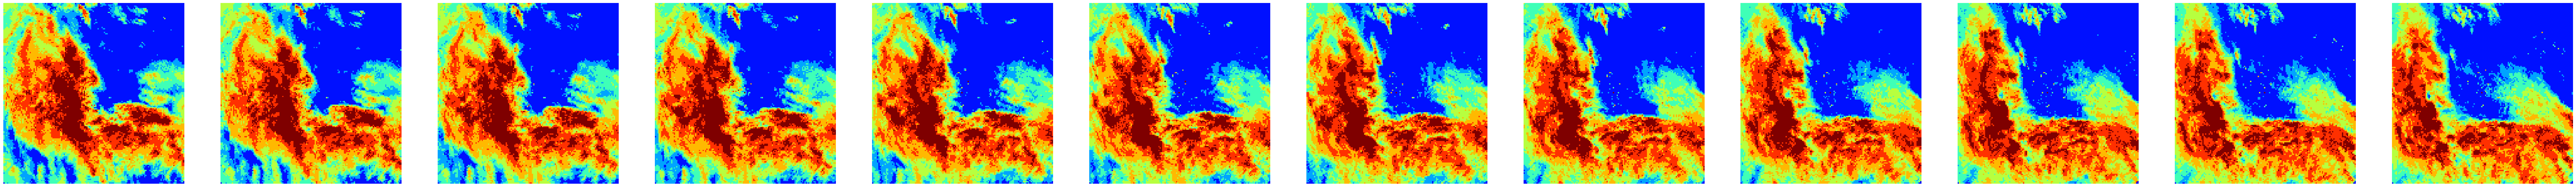

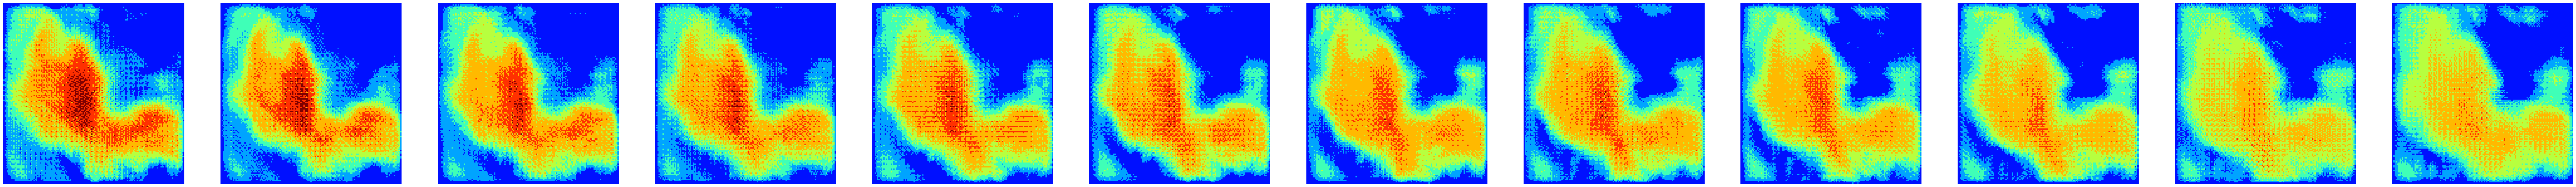

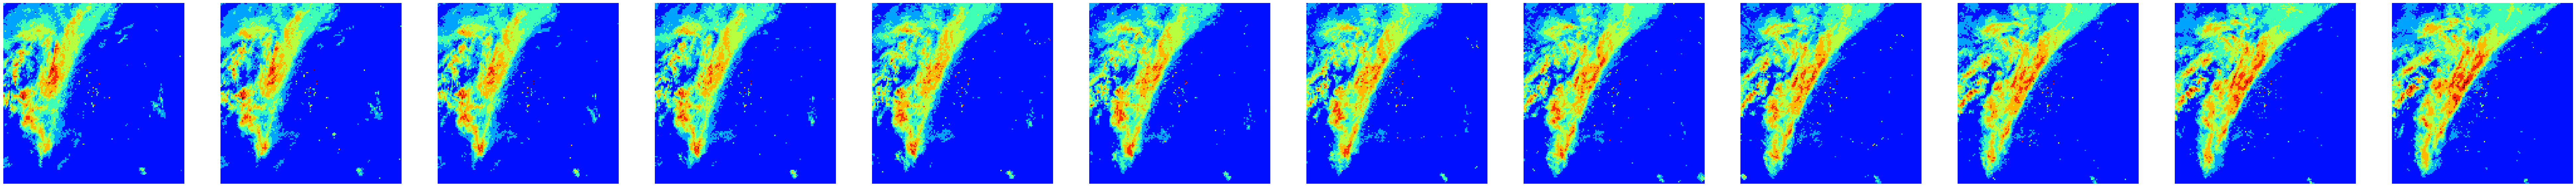

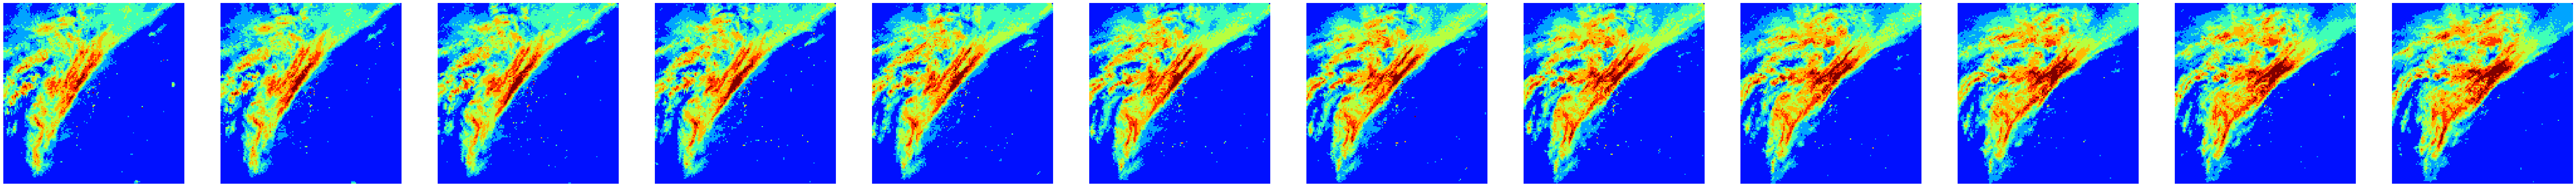

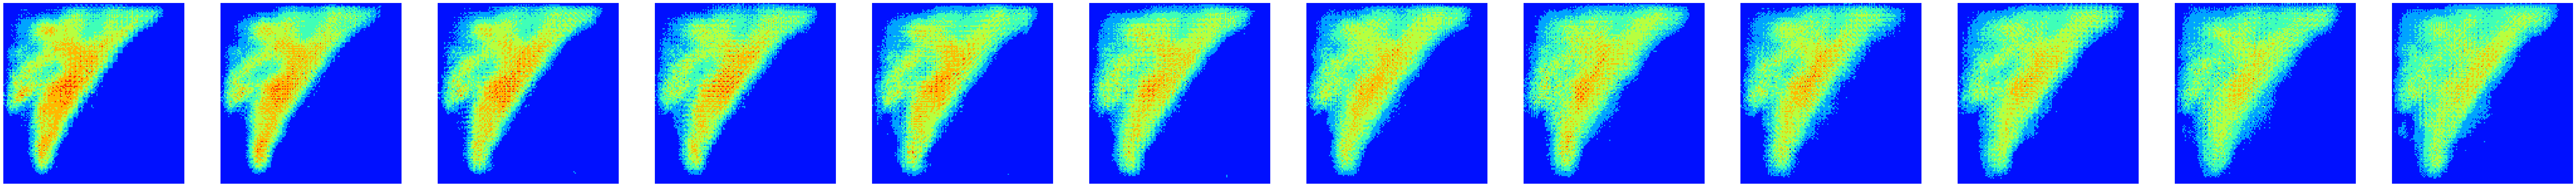

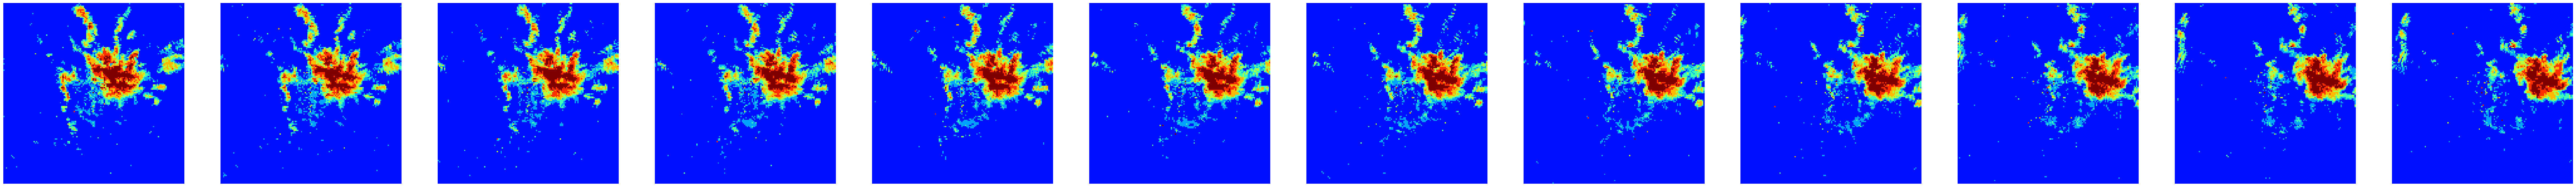

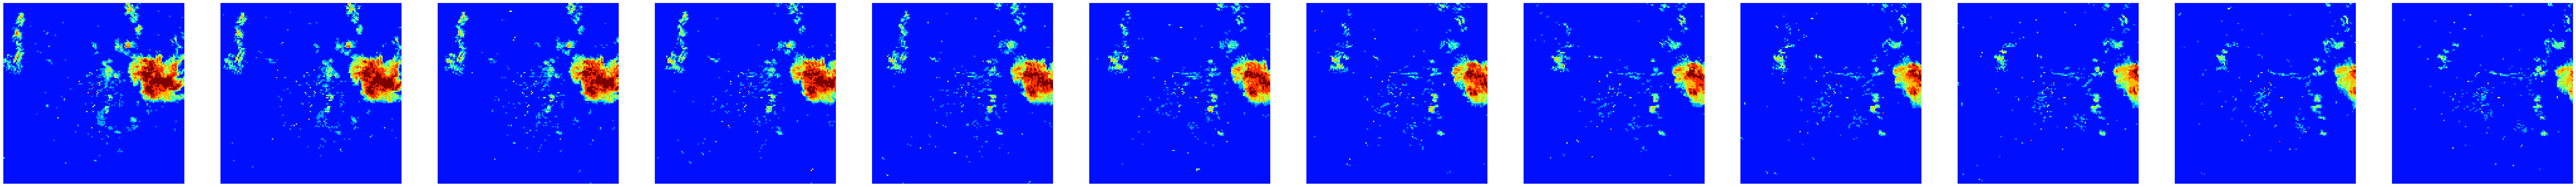

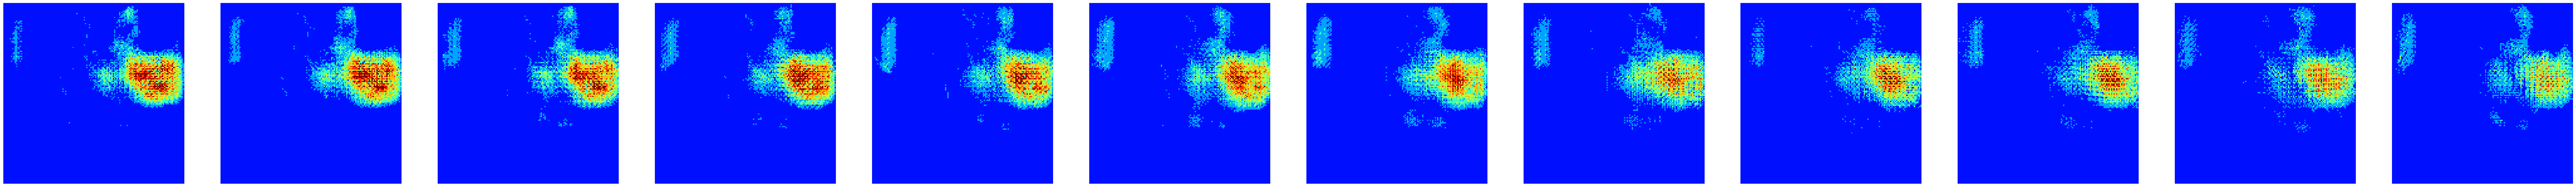

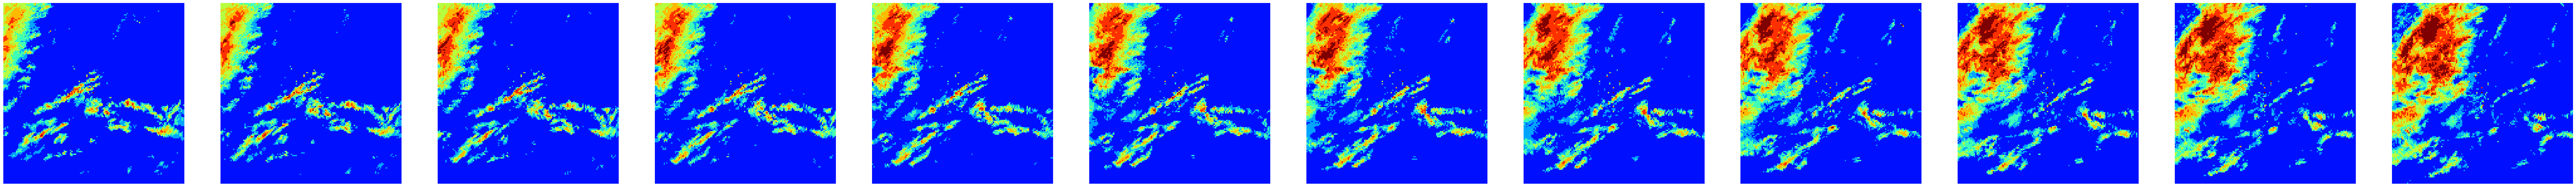

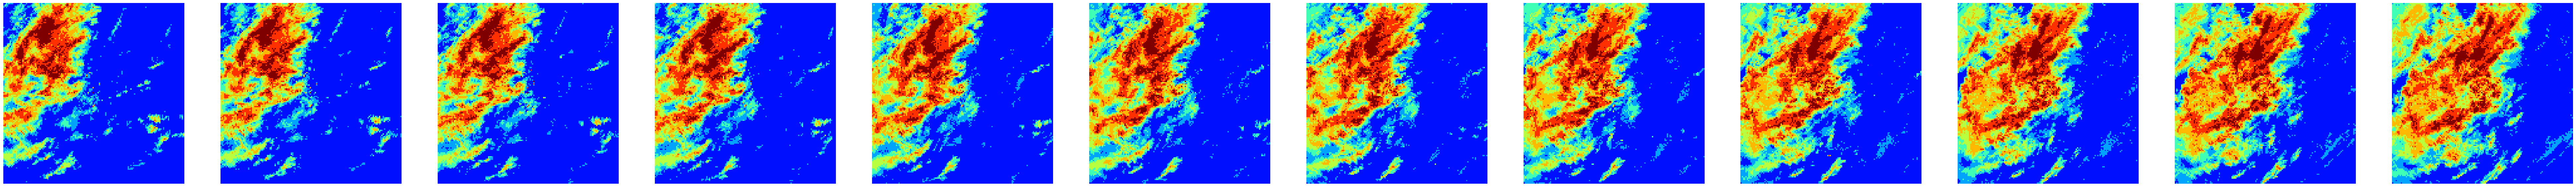

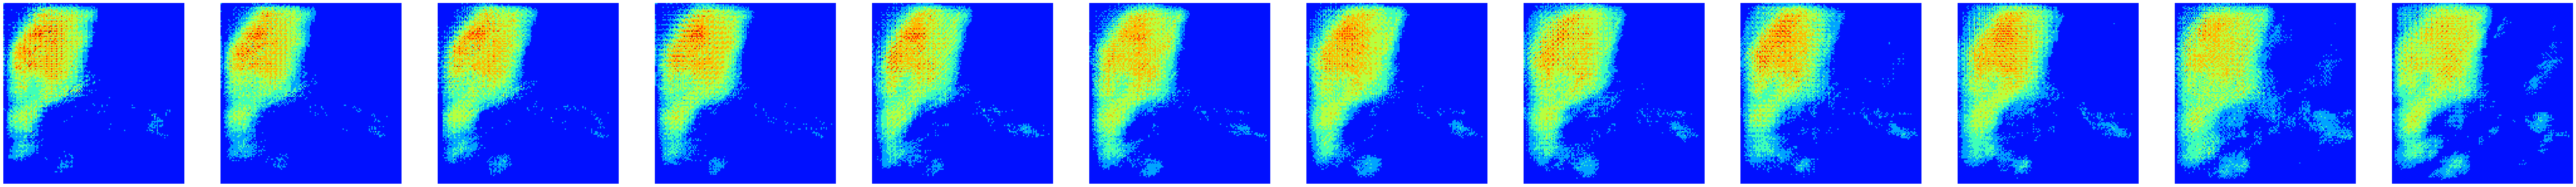

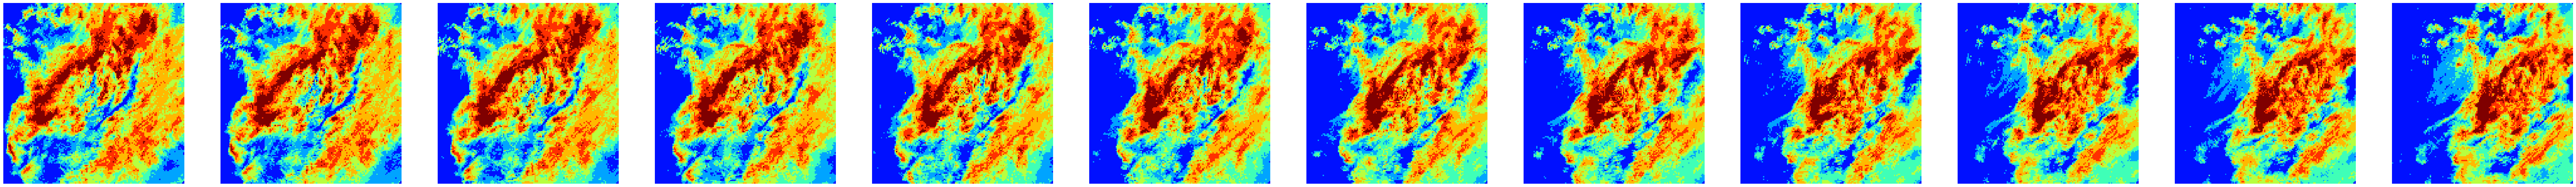

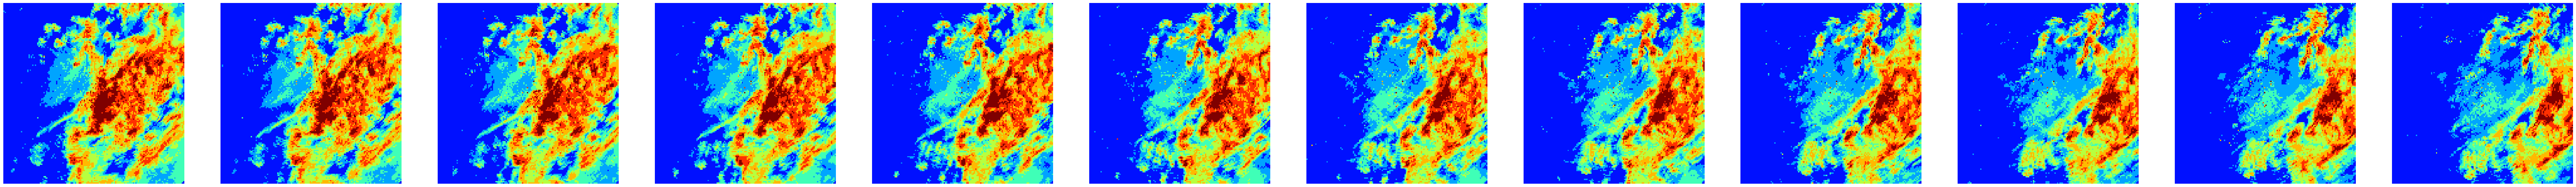

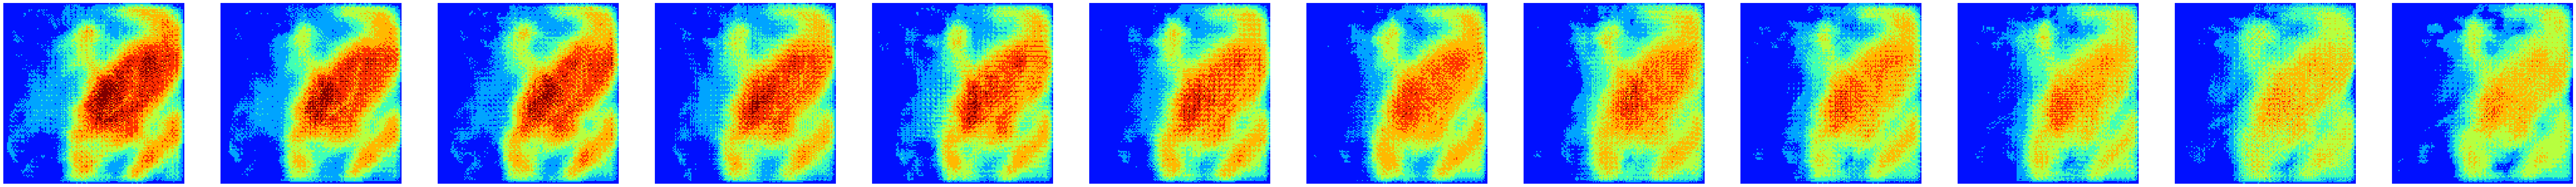

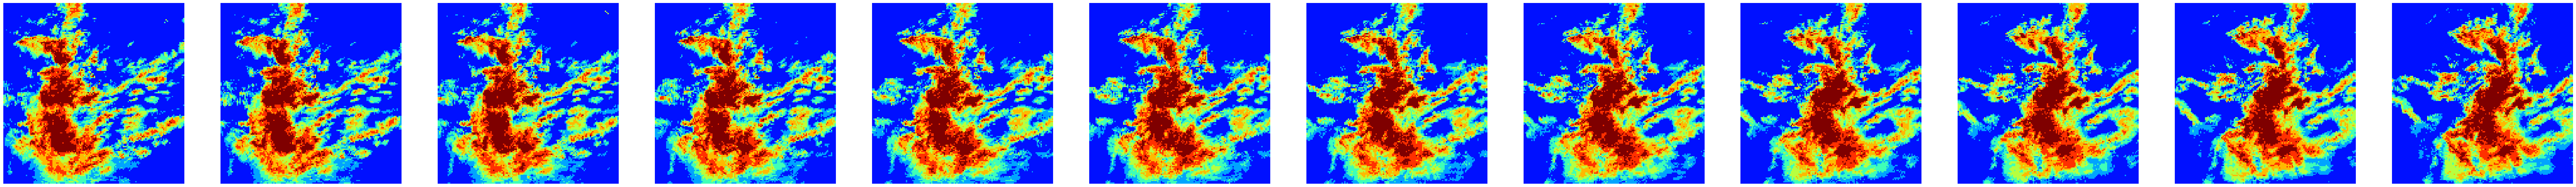

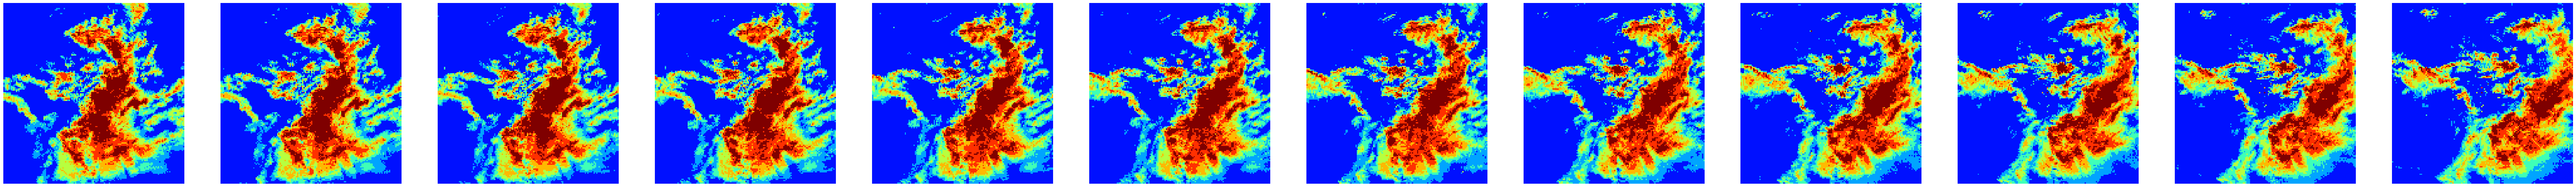

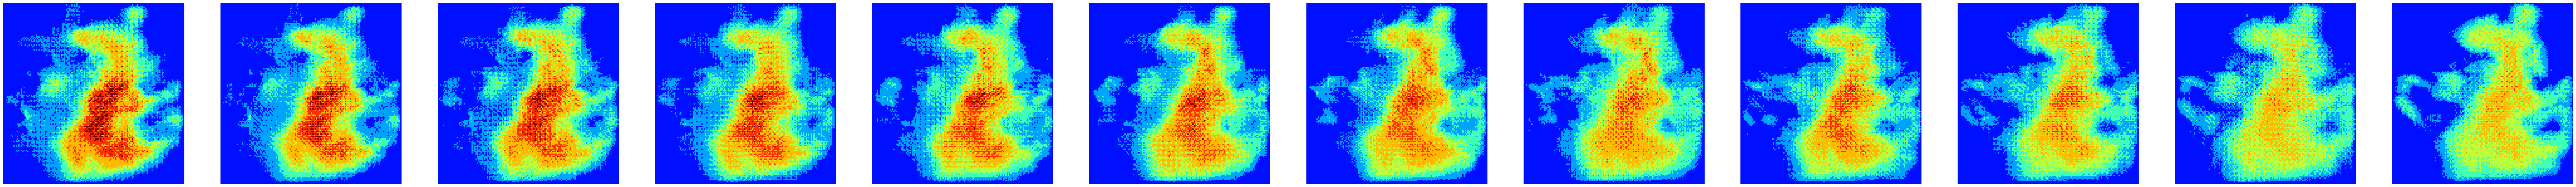

In [31]:
# Classify images into 7 groups of reflectivities
def classify_image(image_tensor):
    # Define the ranges for classification
    ranges = [10., 15., 20., 25., 30., 35., 40., 45., 70.]

    # Initialize an empty tensor to store the classification results
    classified_tensor = torch.zeros_like(image_tensor, dtype=torch.long)

    # Iterate over the ranges and assign class labels based on the conditions
    for i, upper_bound in enumerate(ranges):
        if i == 0:
            mask = (image_tensor >= 0.0) & (image_tensor <= upper_bound)
        else:
            mask = (image_tensor > ranges[i-1]) & (image_tensor <= upper_bound)
        classified_tensor[mask] = i + 1

    return classified_tensor

# Save images for model comparison 
indices= 14, 250,252,262,304,365,370,388     # Images chosen for model comparison


if not os.path.exists('work_dirs/custom_exp/models'):
   os.makedirs('work_dirs/custom_exp/models')

for index in indices:
    fig, axs = plt.subplots(1, 12, figsize=(100,100))
    input_data = torch.Tensor(inputs[index][None,:])
    trues_data = torch.Tensor(trues[index][None,:])
    preds_data = torch.Tensor(preds[index][None,:])
    preds_data[preds_data < 0] = 0
    vmax = torch.max(torch.stack([input_data, trues_data, preds_data]))
    
    # Save input images
    for i in range(12):
        classified_input = classify_image(input_data[0][i][0]*70)
        axs[i].imshow(classified_input,cmap='jet',vmin=0,vmax=7)
        axs[i].axis('off')
    # plt.show()
    plt.savefig(f"work_dirs/custom_exp/models/img{index}_{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}_inputs.jpg",bbox_inches='tight')

    # Save true images
    fig, axs = plt.subplots(1, 12, figsize=(100,100))

    for i in range(12):
        classified_true = classify_image(trues_data[0][i][0]*70)
        axs[i].imshow(classified_true,cmap='jet',vmin=0,vmax=7)
        axs[i].axis('off')
    # plt.show()
    plt.savefig(f"work_dirs/custom_exp/models/img{index}_{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}_trues.jpg",bbox_inches='tight')

    # Save predicted images
    fig, axs = plt.subplots(1, 12, figsize=(100,100))

    for i in range(12):
        classified_pred = classify_image(preds_data[0][i][0]*70)
        axs[i].imshow(classified_pred.float(),cmap='jet',vmin=0,vmax=7)
        axs[i].axis('off')
    plt.savefig(f"work_dirs/custom_exp/models/img{index}_{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}_preds.jpg",bbox_inches='tight')

In [ ]:
# Save the metrics based on confuson matrix for the model

def calculate_metrics(trues, preds, thresh):

    bins = np.array([thresh, 70.])

    preds_thresh = np.digitize(preds_, bins, right=False)
    trues_thresh = np.digitize(trues_, bins, right=False)

    confusion_matrix = metrics.confusion_matrix(
        y_true=trues_thresh.ravel(), y_pred=preds_thresh.ravel(), labels=[True, False]
    )

    # Calculate the confusion matrix
    TP, FP, FN, TN = confusion_matrix[0, 0], confusion_matrix[0, 1], confusion_matrix[1, 0], confusion_matrix[1, 1]

    pod = TP / (TP + FP)  # Probability of detection
    far = FN / (TP + FN)  # False alarm rate
    csi = TP / (TP + FN + FP)  # Critical success index
    hss = ((TP * TN) - (FN * FP)) / (((TP + FN) * (FN + TN)) + ((TP + FN) * (FP + TN)))  # Heidke skill score

    return [[f"csi_{thresh}", csi], [f"hss_{thresh}", hss], [f"pod_{thresh}", pod], [f"far_{thresh}", far]]

# Save the metrics based on confusion matrix for the model

# The thresholds are the reflectivity values in dBZ for which we do the confusion matrix classification
threshs = np.array([10., 20., 30., 40.])
metrics_ = []
# Convert the reflectivity values to dBZ
trues_ = trues * 70
preds_ = preds * 70

for thresh in threshs:
    metrics_.extend(calculate_metrics(trues_, preds_, thresh))
    
# Calculate MSE and MAE for the model
mse = F.mse_loss(torch.Tensor(trues_), torch.Tensor(preds_))
mae = F.l1_loss(torch.Tensor(trues_), torch.Tensor(preds_))

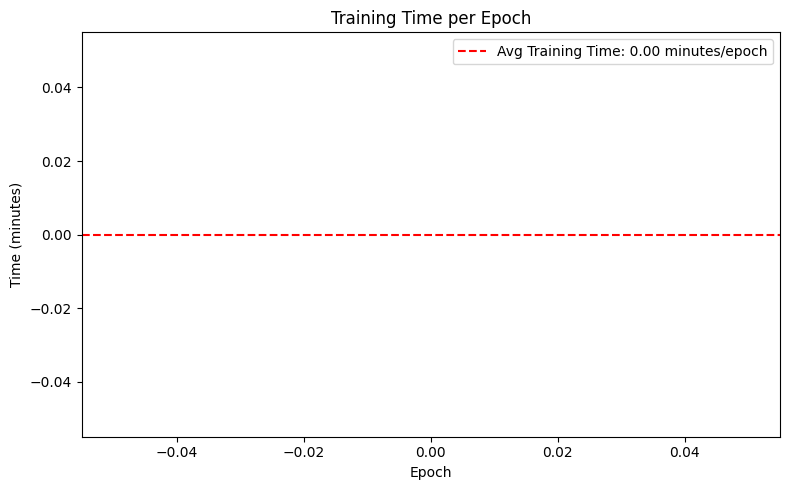

In [ ]:
# Parse log file
def parse_log_line(line):
    match = re.search(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - Epoch', line)
    if match:
        timestamp_str = match.group(1)
        timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S,%f')
        return timestamp
    else:
        return None

# Plot average training time per epoch
def plot_avg_training_time(log_file):
    timestamps = []

    with open(log_file, 'r') as file:
        for line in file:
            result = parse_log_line(line)
            epoch = 0
            if result:
                epoch+=1
                timestamp = result
                timestamps.append((timestamp, epoch))

    # Calculate time differences
    time_diffs = [(timestamps[i][0] - timestamps[i - 1][0]).total_seconds() for i in range(1, len(timestamps))]

    # Calculate average training time per epoch in minutes
    try:
        avg_training_time = (sum(time_diffs) / len(time_diffs)) / 60
    except ZeroDivisionError:
        avg_training_time = 0

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(time_diffs) + 1), [time_diff / 60 for time_diff in time_diffs], marker='o', linestyle='-', color='b')
    plt.axhline(avg_training_time, color='r', linestyle='--', label=f'Avg Training Time: {avg_training_time:.2f} minutes/epoch')
    plt.title('Training Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (minutes)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return avg_training_time
# Example usage
m_epoch = plot_avg_training_time(log_file_path)

In [ ]:
# Write the metrics in a text file
with open(f"work_dirs/custom_exp/models/{exp.args.model_type}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}_metrics.txt","w") as f:
    f.write(f"MSE : {mse}, MAE : {mae} \n\n Nb params : {nb_params}, FLOPs : {flops}, Training time : {m_epoch} m/epoch,  \n\n Now-casting metrics : \n\n")
    for i,line in enumerate(metrics_):
        f.write(str(line)+"\n\n")

In [ ]:
# Save the models parameters

torch.save(exp.method.state_dict(), f"work_dirs/custom_exp/models/{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_params.pth")